# Analyse de sensibilité globale avec les indices de Sobol'

**Application au cas de la déviation verticale d'une poutre encastrée.**

## Références
- http://openturns.github.io/openturns/master/user_manual/_generated/openturns.SaltelliSensitivityAlgorithm.html
- http://openturns.github.io/openturns/master/user_manual/_generated/openturns.SobolIndicesAlgorithm.html

## Déviation verticale d'une poutre encastrée

Nous considérons une poutre encastrée définie par son module de Young $E$, sa longueur $L$ et son moment d'inertie $I$. Une extrémité est encastrée dans un mur et nous appliquons une charge $F$ à l'autre extrémité de la poutre, ce qui entraîne une déviation verticale $Y$, également nommée « flèche » en mécanique.

Nous analysons la déviation verticale produite par un enfant sur un plongeoir. Nous considérons un enfant dont le poids génère une force approximativement égale à 300 N (c'est-à-dire environ 30 kg). En raison des incertitudes sur le poids de la personne, nous considérons que la force est une variable aléatoire. La longueur du plongeoir est comprise entre 2,5 m et 2,6 m. Le module de Young est incertain et compris entre 65 et 75 GPa (c'est-à-dire entre $65 \times 10^9$ et $75 \times 10^9$ Pascals), ce qui correspond à de la fibre de verre, un matériau souvent utilisé pour les plongeoirs. Les incertitudes liées à la production du matériau sont prises en compte dans le module de Young et le moment d'inertie du plongeoir.

<img src="poutre.png" width="200">

**Figure 1.** Déviation verticale $Y$ de la poutre encastrée de longueur $L$.

## Entrées

- $E$ : Module de Young (en Pa),
- $F$ : Charge (en N),
- $L$ : Longueur de la poutre (en m),
- $I$ : Moment d'inertie (en $\textrm{m}^4$).

| Variable | Distribution                                                                      |
| -------- | --------------------------------------------------------------------------------- |
| E        | Beta(alpha = 0.9, beta = 3.5, a = $65 \times 10^9$, $b = 75 \times 10^9$)         |
| F        | Lognormal($\mu_F=300 $, $\sigma_F=30$, $\gamma$=0)                                   |
| L        | Uniform(min=2.5, max= 2.6)                                                        |
| I        | Beta(alpha = 2.5, beta = 4.0, a = $1.3 \times 10^{-7}$, b = $1.7 \times 10^{-7}$) |

**Tableau 1.** Lois marginales des variables $E$, $F$, $L$ et $I$.

Dans le tableau précédent, $\mu_F = \mathbb{E}[F]$ et $\sigma_F = \sqrt{\operatorname{Var}(F)}$ désignent la moyenne et l'écart-type de $F$. Les variables d'entrée sont supposées indépendantes.

**Remarque.** La variable $F$ est de loi Log-Normale. Il serait possible de paramétrer cette variable aléatoire en spécifiant la moyenne et l'écart-type de la variable gaussienne sous-jacente. Ce n'est toutefois pas ce qui est réalisé ici : nous spécifions la moyenne et l'écart-type de la variable $F$ elle-même. C'est la raison pour laquelle nous utiliserons par la suite la classe `LogNormalMuSigma`.

**Remarque.** Les paramètres de forme de la loi Beta ($\alpha=0.9$ et $\beta=3.5$) modélisent une asymétrie marquée vers la borne inférieure, représentative d'un biais de fabrication tendant vers la spécification minimale du matériau. 

## Sortie d'intérêt

Le déplacement vertical à l'extrémité libre de la poutre encastrée est :
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}.
$$

## Quantité d'intérêt

Nous souhaitons estimer les indices de Sobol' du premier ordre et totaux. Nous pouvons le faire, car les variables aléatoires en entrée du modèle physique sont indépendantes.

L'indice de Sobol' du premier ordre est :

$$
S_i = \frac{\operatorname{Var}(\mathbb{E}[Y|X_i])}{\operatorname{Var}(Y)}
$$

pour $1 \leq i \leq d$ où $Y = g(\boldsymbol{X})$ et $\boldsymbol{X}$ est le vecteur aléatoire en entrée du modèle physique $g$.

L'indice de Sobol' total est :

$$
S_i^T = 1 - \frac{\operatorname{Var}(\mathbb{E}[Y|\boldsymbol{X}_{-i}])}{\operatorname{Var}(Y)}
$$

pour $1 \leq i \leq d$ où $\boldsymbol{X}_{-i} = (X_1, \ldots, X_{i-1}, X_{i+1}, \ldots, X_d)$ est un vecteur aléatoire en dimension $d - 1$.


# Model definition

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import tabulate

In [2]:
ot.RandomGenerator.SetSeed(1976)

dist_E = ot.Beta(0.9, 3.5, 65.0e9, 75.0e9)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(300.0, 30.0, 0.0)  # Paramétrage par les moments
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(2.50, 2.60)  # in m
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4.0, 1.3e-7, 1.7e-7)  # in m^4
dist_I.setDescription(["I"])

X = ot.JointDistribution([dist_E, dist_F, dist_L, dist_I])

g = ot.SymbolicFunction(["E", "F", "L", "I"], ["F* L^3 /  (3 * E * I)"])
g.setOutputDescription(["Y (m)"])

Pour pouvoir exploiter au mieux les simulations, nous équipons la fonction d'un mécanisme d'historique.

In [3]:
g = ot.MemoizeFunction(g)

Enfin, nous définissons le vecteur aléatoire de sortie.

In [4]:
XRV = ot.RandomVector(X)
Y = ot.CompositeRandomVector(g, XRV)
Y.setDescription(["Y (m)"])

## Estimer les indices de Sobol' avec un budget fixé

Le composant d'estimation des indices de Sobol' est équipé d'un système qui permet d'évaluer la fonction en dehors d'OpenTURNS. Pour l'utiliser, on crée un type de plan d'expériences spécial en utilisant la classe `SobolIndicesExperiment`. La méthode `generate` permet de créer le plan d'expériences associé à une taille fixée par l'utilisateur. 

In [5]:
size = 500
computeSecondOrder = False
sie = ot.SobolIndicesExperiment(X, size, computeSecondOrder)
inputDesign = sie.generate()

La taille `size` est la taille du plan Monte-Carlo de base, utilisé pour obtenir un estimateur. Or plusieurs estimations sont requises dans ce cas particulier :

- une estimation de la moyenne de Y c'est à dire $\mathbb{E}[Y]$ et une estimation de la variance de Y c'est à dire $\operatorname{Var}(Y)$,
- une estimation des quatre indices du premier ordre $S_E$, $S_F$, $S_L$, $S_I$,
- une estimation des quatre indices totaux $T_E$, $T_F$, $T_L$, $T_I$.

Pour estimer ces quantités, la méthode _pick-freeze_ requiert :

* un plan d'expériences de type "A",
* un plan d'expériences de type "B",
* des plans d'expériences de type "E" dont le nombre est égal à la dimension du vecteur d'entrée.

Il y a donc ici 4 plans d'expériences de type "E".

C'est pour cette raison que la taille du plan d'expériences permettant d'estimer toutes les quantités requises est égal à (1+1+4) * 500 = 3000.

In [6]:
inputDesign.getSize()

3000

In [7]:
outputDesign = g(inputDesign)

La bibliothèque dispose de quatre estimateurs des indices de Sobol'. Ici, nous proposons d'utiliser l'estimateur de Saltelli. 

In [8]:
sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(inputDesign, outputDesign, size)

On souhaite obtenir la distribution asymptotique.

In [9]:
sensitivityAnalysis.setUseAsymptoticDistribution(True)

Les méthodes `getFirstOrderIndices` et `getTotalOrderIndices` permettent de récupérer les indices du premier ordre et totaux.

In [10]:
firstOrderIndices = sensitivityAnalysis.getFirstOrderIndices()
print("First order:", firstOrderIndices)

First order: [0.0163206,0.684515,0.0431776,0.131372]


In [11]:
totalOrderIndices = sensitivityAnalysis.getTotalOrderIndices()
print("Total order:", totalOrderIndices)

Total order: [0.0657028,0.726716,0.0812739,0.161218]


La méthode `draw` propose une méthode de dessin des indices de Sobol' qui permet d'observer à la fois les indices du premier ordre, les indices totaux et les intervalles de confiance.

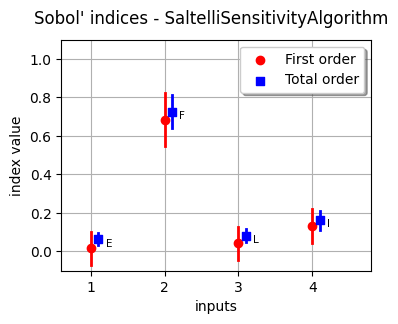

In [12]:
graph = sensitivityAnalysis.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Considérons en particulier la variable F. On observe que l'estimation de l'indice de sensibilité du premier ordre est légèrement supérieur à l'estimation de l'indice total. On sait que les valeurs exactes sont toujours de telle sorte que l'indice total est supérieur ou égal à l'indice du premier ordre. C'est donc à cause de l'erreur d'estimation que l'on obtient un ordre inverse. C'est la marque que 

- la taille de l'échantillon n'est pas suffisamment grande,
- ou l'indice du premier ordre est égal à l'indice total car il n'y a pas d'interaction.

Dans ce cas particulier, on observe que l'intervalle de confiance à 95% indique que l'estimation de l'indice du premier ordre de F est particulièrement large, approximativement entre 0.6 et 1.1. Dans ce cas particulier, il est pertinent d'augmenter la taille de l'échantillon.

La méthode `DrawSobolIndices` permet de réaliser un graphique similaire lorsque les indices sont déjà disponibles.

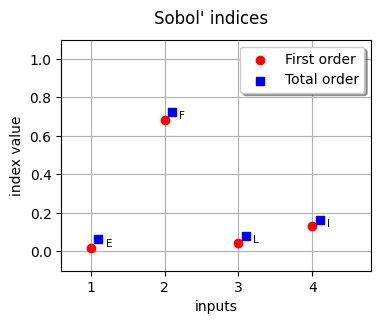

In [13]:
inputDescription = X.getDescription()
graph = ot.SaltelliSensitivityAlgorithm.DrawSobolIndices(
    inputDescription, firstOrderIndices, totalOrderIndices
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

La méthode `getFirstOrderIndicesDistribution` retourne la distribution des indices de Sobol'. Elle peut être de deux types différents.

- Par défaut, la distribution des indices de Sobol' est estimée par ré-échantillonnage avec remise (nommé « _bootstrap_ » en anglais). Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `KernelMixture`, c'est à dire fondée sur une méthode d'estimation par lissage à noyau.
- Si on utilise la méthode `setUseAsymptoticDistribution`, alors on peut obtenir la distribution asymptotique fondée sur la méthode delta. Dans ce cas, la valeur de retour de `getFirstOrderIndicesDistribution` est de type `Normal`.

In [14]:
fo_dist = sensitivityAnalysis.getFirstOrderIndicesDistribution()
fo_dist

class=Normal name=Normal dimension=4 mean=class=Point name=Unnamed dimension=4 values=[0.0163206,0.684515,0.0431776,0.131372] sigma=class=Point name=Unnamed dimension=4 values=[0.0445144,0.0699642,0.04396,0.0444308] correlationMatrix=class=CorrelationMatrix dimension=4 implementation=class=MatrixImplementation name=Unnamed rows=4 columns=4 values=[1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1]

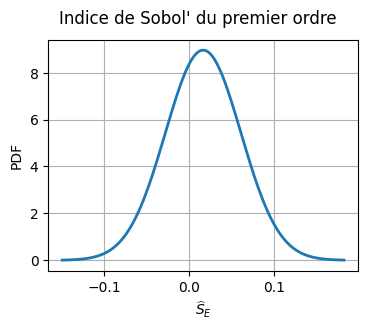

In [15]:
fo_SX0 = fo_dist.getMarginal(0)
graph = fo_SX0.drawPDF()
graph.setXTitle(r"$\widehat{S}_{" + inputDescription[0] + "}$")
graph.setTitle("Indice de Sobol' du premier ordre")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Estimer les indices de Sobol' avec un algorithme itératif

La classe `SobolSimulationAlgorithm` permet d'estimer les indices de Sobol' à l'aide d'un algorithme itératif. L'objectif principal de cette classe est de pouvoir configurer la précision d'estimation de l'indice de Sobol' à l'aide d'un intervalle de confiance dont le niveau de confiance `alpha` et la largeur `epsilon` sont fixés par l'utilisateur. Ainsi, les simulations sont réalisées par bloc, ce qui garantit à la fois une performance maximale sur les supercalculateurs et un nombre minimal de blocs évalués. Le paramètre `block_size` permet d'obtenir un estimateur asymptotique. Le paramètre `batch_size` permet d'obtenir une évaluation parallèle du modèle physique `g`. 

In [16]:
alpha = 0.05  # i.e. 95% confidence interval
epsilon = 0.2  # Confidence interval length
block_size = 50  # size of Sobol experiment at each iteration
design_size = 16  # number of points evaluated simultaneously
maximumOuterSampling = 400  # number of outer iterations of the algorithm

estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)
algo = ot.SobolSimulationAlgorithm(X, g, estimator)
algo.setMaximumOuterSampling(maximumOuterSampling)  # Number of iterations
algo.setBlockSize(block_size)
algo.setExperimentSize(design_size)
algo.setIndexQuantileLevel(alpha)  # alpha
algo.setIndexQuantileEpsilon(epsilon)  # epsilon
algo.run()

result = algo.getResult()
fo = result.getFirstOrderIndicesEstimate()
to = result.getTotalOrderIndicesEstimate()
print("First order = %s" % (str(fo)))
print("Total order = %s" % (str(to)))

First order = [0.0681902,0.844905,0.128276,0.2084]
Total order = [0.0364376,0.747835,0.0794675,0.172353]


In [17]:
outerSampling = result.getOuterSampling()
print("outerSampling = ", outerSampling)
if outerSampling == maximumOuterSampling:
    print("Attention : le nombre maximum d'itérations externes est atteint!")

outerSampling =  188


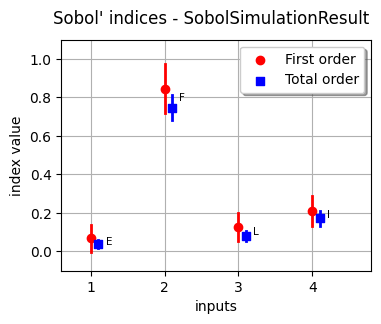

In [18]:
graph = result.draw()
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

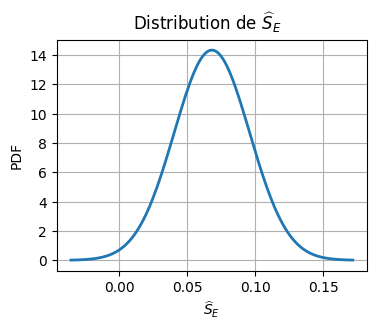

In [19]:
dist_fo = result.getFirstOrderIndicesDistribution()
dist_fo_i = dist_fo.getMarginal(0)
graph = dist_fo_i.drawPDF()
graph.setTitle(r"Distribution de $\widehat{S}_E$")
graph.setXTitle(r"$\widehat{S}_E$")
graph.setLegends([""])
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

In [20]:
data = []
input_description = g.getInputDescription()
#
alpha = 0.95
dimension = g.getInputDimension()
distribution_first_order = result.getFirstOrderIndicesDistribution()
distribution_total = result.getTotalOrderIndicesDistribution()
for i in range(dimension):
    # First order
    marginal_first_order = distribution_first_order.getMarginal(i)
    interval = marginal_first_order.computeBilateralConfidenceInterval(alpha)
    lower_first_order = interval.getLowerBound()[0]
    upper_first_order = interval.getUpperBound()[0]
    # Total
    marginal_total = distribution_total.getMarginal(i)
    interval = marginal_total.computeBilateralConfidenceInterval(alpha)
    lower_total = interval.getLowerBound()[0]
    upper_total = interval.getUpperBound()[0]
    #
    data.append(
        [
            f"{input_description[i]}",
            f"[{lower_first_order:.2f}, {upper_first_order:.2f}]",
            f"[{lower_total:.2f}, {upper_total:.2f}]",
        ]
    )

#
print("Table 1. Estimation des indices de Sobol'.")
tabulate.tabulate(
    data,
    tablefmt="html",
    headers=[
        "Variable",
        f"Premier ordre, I.C. {alpha*100.0}%",
        f"Total, I.C. {alpha*100.0}%",
    ],
)

Table 1. Estimation des indices de Sobol'.


Variable,"Premier ordre, I.C. 95.0%","Total, I.C. 95.0%"
E,"[0.01, 0.12]","[0.02, 0.05]"
F,"[0.75, 0.94]","[0.70, 0.80]"
L,"[0.07, 0.18]","[0.06, 0.10]"
I,"[0.15, 0.27]","[0.14, 0.20]"


## Analyse des indices de Sobol'

Voici les conclusions que l'on peut tirer.

- La variable $F$ est la variable qui contribue le plus à la variabilité de la sortie, à hauteur de 70 à 90%.
- La variable $I$ est la seconde variable qui contribue le plus à la variabilité de la sortie, à hauteur de 10 à 20%.
- Les deux autres variables $E$ et $L$ contribuent à moins de 10 % de la variabilité de la sortie : elles pourraient être remplacées par des constantes (surtout la variable $E$), sans que la variabilité de la sortie $Y$ ne soit beaucoup modifiée.
- Sur la base des calculs, on peut indiquer que les interactions, si elles existent, ne contribuent pas beaucoup à la variabilité de la sortie. 

**Remarque.** Les indices de Sobol' sont compris entre 0 et 1. Toutefois, une estimation d'un indice de Sobol' peut être négative ou supérieure à 1. Cela est dû à la taille finie de l'échantillon, ce qui implique une certaine variabilité de l'estimateur. De même, l'indice de Sobol' du premier ordre est inférieur ou égal à l'indice de Sobol' total. Pour la même raison que précédemment, pour une variable $X_i$, l'estimation de l'indice total peut être inférieure à l'estimation de l'indice du premier ordre.

## Exercice 1 : fonction produit

On considère la fonction :
$$
g(X_1,X_2)=X_1 X_2
$$
pour tout $X_1,X_2\in\mathbb{R}$. 
On suppose que les variables sont indépendantes et suivent les lois suivantes.

| Variable | Distribution |
|--|--|
| $X_1$ | Normal($\mu=0$, $\sigma=10$) |
| $X_2$ | Uniforme($a=-1$, $b=1$) |

**Table 1.** Modèle probabiliste du modèle physique de produit.

La cellule suivante définit le modèle.

In [21]:
g = ot.SymbolicFunction(["X1", "X2"], ["X1 * X2"])
X1 = ot.Normal(0.0, 10.0)
X2 = ot.Uniform(-1.0, 1.0)
X = ot.JointDistribution([X1, X2])
inputDescription = ["X1", "X2"]
X.setDescription(inputDescription)

**Questions.**

- Estimer les indices SRC. Pour cela, utiliser la classe `CorrelationAnalysis().computeSquaredSRC()`. 
- Pour valider vos résultats, utiliser la fonction `CorrelationAnalysis.computeLinearCorrelation()` :

```python
ot.CorrelationAnalysis(sampleX, sampleY).computeLinearCorrelation()
```

Comparer vos résultats : qu'observez-vous ?

- Estimer les indices de Sobol' avec la classe `SaltelliSensitivityAlgorithm`. Qu'observez-vous ? Comment expliquer ce résultat ?

## Exercice 2 : fonction Ishigami

On considère la fonction 

$$
g(X_1,X_2,X_3) = \sin(X_1)+a \sin (X_2)^2 + b X_3^4 \sin(X_1)
$$

pour tout $X_1,X_2,X_3\in[-\pi,\pi]$ où $a=7$ et $b=0.1$. 
On suppose que les variables sont indépendantes et suivent la loi uniforme entre $-\pi$ et $\pi$.

La cellule suivante définit le modèle.

In [22]:
input_names = ["X1", "X2", "X3"]
g = ot.SymbolicFunction(
    input_names, ["sin(X1) + 7.0 * sin(X2)^2 + 0.1 * X3^4 * sin(X1)"]
)
X = ot.JointDistribution([ot.Uniform(-np.pi, np.pi)] * 3)
X.setDescription(input_names)

**Questions.**

- Estimer les indices SRC carrés avec la classe `CorrelationAnalysis.computeSquaredSRC()`
- Estimer les indices SRC carrés avec la classe `CorrelationAnalysis.computeLinearCorrelation()`. 
- Estimer les indices de Sobol'. 
- Qu'observez-vous ?

## Exercice 3 : variabilité de l'estimateur

On considère le cas de la déviation verticale de la poutre encastrée. Avec une méthode Monte-Carlo et l'estimateur de Saltelli, on souhaite observer la variabilité de l'estimateur des indices du premier ordre. Pour cela, nous allons répéter l'estimation des indices du premier ordre $r$ fois, avec $r=100$. Dans chaque expérience, nous allons estimer les indices du premier ordre avec un plan d'expériences de taille $n$, avec $n=500$.

**Questions.**

- Créer la variable `r=100`. 
- Créer la variable `sampleS` contenant un `Sample` de taille `r` et de dimension 4. Cette variable est destinée à contenir l'échantillon des estimations des indices du premier ordre.
- Créer la variable `n=500`.
- Créer une boucle `for` de 0 à `r-1`. Pour chaque élément `j` de la boucle, estimer les indices du premier ordre et stocker le résultat dans `sampleS[j,:]`.
- Dessiner l'histogramme empirique de l'indice de Sobol' du premier ordre pour la variable $E$
- Dessiner la loi gaussienne asymptotique issue de la méthode `getFirstOrderIndicesDistribution`. Est-ce que les deux distributions sont comparables ?

## Exercice 4 : estimation par échantillonnage

On considère le cas de la déviation verticale de la poutre encastrée. On souhaite mettre en oeuvre la méthode fondée sur l'échantillonnage pour estimer les indices de sensibilité. Dans le contexte de la quantification des incertitudes, cette méthode est nommée « _pick-freeze_ » en anglais.

**Questions.**

- En utilisant une méthode Monte-Carlo, développez le script fondé sur l'estimateur de Saltelli centré et une boucle `for` pour estimer les indices de Sobol' du premier ordre et les indices totaux. On peut utiliser la fonction `sampleDotProduct` qui facilite le travail.
- Créer le script permettant d'estimer les indices grâce à l'estimateur de Martinez. Pour cela, utiliser la méthode `CorrelationAnalysis.computeLinearCorrelation()`. Estimer les indices de Sobol'. Comparer avec les valeurs précédentes : qu'observez-vous ?
- Comparez les résultats produits par les deux méthodes : qu'observez-vous ?


In [23]:
def sampleDotProduct(sampleA, sampleB):
    """
    Computes the dot product of two 1D-samples.

    Parameters
    ----------
    sampleA : ot.Sample(size, 1)
        A sample.
    sampleB : ot.Sample(size, 1)
        A sample.

    Returns
    -------
    y : float
        The dot product of sampleA and sampleB.

    """
    sampleA_point = sampleA.asPoint()
    sampleB_point = sampleB.asPoint()
    y = sampleA_point.dot(sampleB_point)
    return y

## Exercice 5 : utilisation d'une séquence de Sobol' pour estimer les indices de Sobol'

Utiliser un plan d'expériences de type séquence à faible discrépance pour estimer les indices de sensibilité. Pour cela, on utilisera la séquence de Sobol'. 

Pour clarifier l'algorithme, on définira la fonction `martinezSobolIndices` qui utilisera l'estimateur de Martinez pour estimer les indices de Sobol'. Sa séquence d'appel devra être :

```python
S, T = martinezSobolIndices(XA, XB)
```

Nous proposons d'utiliser cette fonction de telle sorte que `XA` et `XB` sont issus d'une séquence à faible discrépance de taille n en dimension $2p$. Puis, on découpera ce plan d'expériences en deux plans d'expériences de dimension $p$. La séquence de Sobol' peut être générée grâce aux classes `SobolSequence` et `LowDiscrepancyExperiment`. 
